# Statistical Machine Learning Final Project: Customer Churn Prediction 🏦
### Authors: Ava, Sam, Taylor, Jordan

# ML Final Project: Customer Churn

**Goal:** Predict whether a bank customer will churn (close their account) and understand which features drive churn.  
**Data:** `customer_churn.csv` (10,000 customers, binary `churn` variable, mix of numeric + categorical predictors).  
**Task type:** Binary classification

## Imports & Exploratory Data Analysis: Ava

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the ]8;;http://conflicted.r-lib.org/conflicted package]8;; to force all conflicts to become errors
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘recipes’

The following object is masked from ‘package:stringr’:

    fixed

The following object is masked from ‘pac

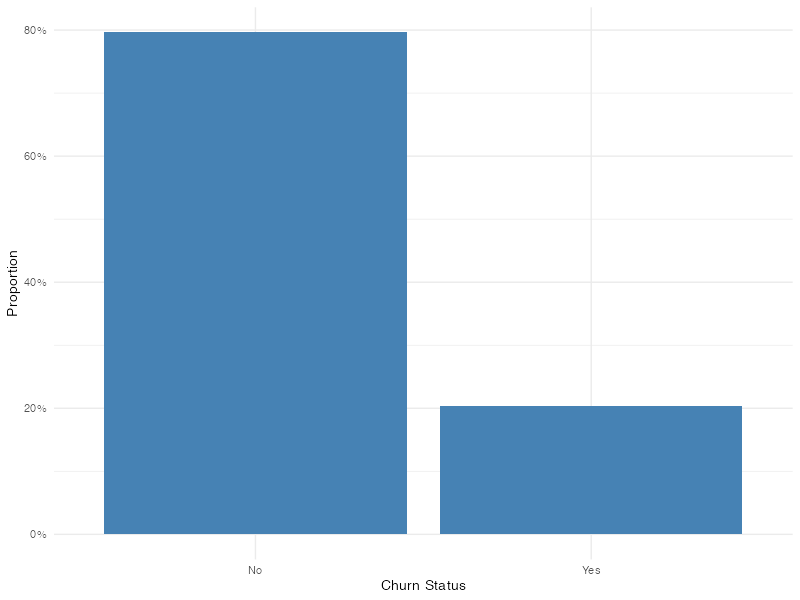

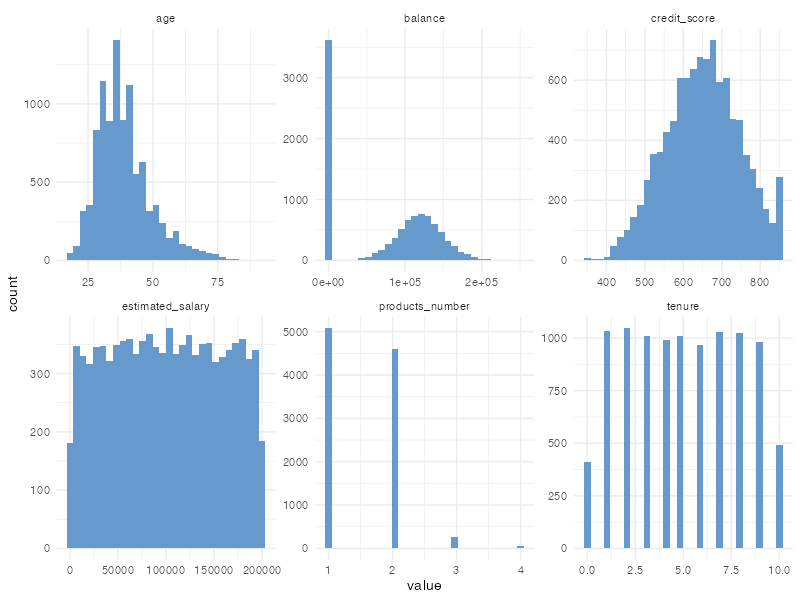

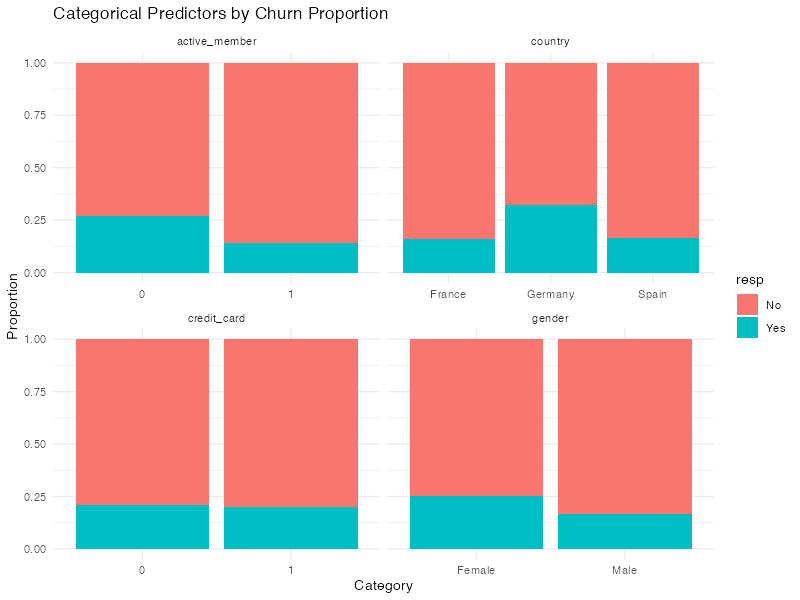

                 credit_score   age tenure balance products_number estimated_salary
credit_score             1.00  0.00   0.00    0.01            0.01             0.00
age                      0.00  1.00  -0.01    0.03           -0.03            -0.01
tenure                   0.00 -0.01   1.00   -0.01            0.01             0.01
balance                  0.01  0.03  -0.01    1.00           -0.30             0.01
products_number          0.01 -0.03   0.01   -0.30            1.00             0.01
estimated_salary         0.00 -0.01   0.01    0.01            0.01             1.00

In [2]:
# MACHINE LEARNING PROJECT — EDA + PREPROCESSING ONLY
# NOTE: No CreateCV() here. No modeling yet.
# We only explore, clean, and define recipes for later use.

# 1. Load Libraries
packages <- c("tidyverse", "caret", "recipes", "janitor", "pROC", "themis")
to_install <- packages[!packages %in% installed.packages()[, "Package"]]
if (length(to_install)) install.packages(to_install, repos = "https://cloud.r-project.org")

lapply(packages, library, character.only = TRUE)

# 2. Import Dataset + Clean Names
data <- read_csv(
  "https://raw.githubusercontent.com/samstrc/StatML-Final-Proj/refs/heads/main/customer_churn.csv",
  show_col_types = FALSE
) %>%
  janitor::clean_names()

glimpse(data)
summary(data)
names(data)

# 3. Drop ID Column
df <- data %>%
  select(-customer_id)

# 4. Convert categoricals to factors, rename churn to resp, and move resp to first column
df <- df %>%
  mutate(
    resp          = factor(churn, levels = c(0, 1), labels = c("No", "Yes")),
    country       = factor(country),
    gender        = factor(gender),
    credit_card   = factor(credit_card),    
    active_member = factor(active_member)    
  ) %>%
  select(resp, everything(), -churn)

table(df$resp)

# 5. BASIC EDA
# Missing values
colSums(is.na(df))

# Check class imbalance ------------
ggplot(df, aes(x = resp)) +
  geom_bar(aes(y = after_stat(count/sum(count))), fill = "steelblue") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(y = "Proportion", x = "Churn Status") +
  theme_minimal()

table(df$resp)
prop.table(table(df$resp))

# Numeric Histograms ------------------
df %>%
  select(where(is.numeric)) %>%
  pivot_longer(cols = everything(),
               names_to = "variable",
               values_to = "value") %>%
  ggplot(aes(value)) +
  geom_histogram(bins = 30, fill = "#6699CC") +
  facet_wrap(~ variable, scales = "free") +
  theme_minimal()


# Barplots for categorical predictors -----------------------
df %>%
  select(country, gender, credit_card, active_member, resp) %>%
  mutate(
    credit_card   = factor(credit_card),
    active_member = factor(active_member)
  ) %>%
  pivot_longer(
    cols = -resp,
    names_to = "variable",
    values_to = "value"
  ) %>%
  ggplot(aes(x = value, fill = resp)) +
  geom_bar(position = "fill") +
  facet_wrap(~ variable, scales = "free_x") +
  labs(
    y = "Proportion",
    x = "Category",
    title = "Categorical Predictors by Churn Proportion"
  ) +
  theme_minimal()

# Correlation Matrix for Numeric Predictors ----------------------
numeric_df <- df %>% select(where(is.numeric))
round(cor(numeric_df), 2)

### EDA Summary
The dataset is heavily imbalanced with approximately 80% non-churners and 20% churners. Predictor distributions vary widely: credit score is roughly normal, age is skewed slightly older, and estimated salary is uniform. Several predictors such as balance and products_number show noticeably skewed distributions and spikes at zero. Correlations among numeric variables are generally weak, suggesting little multicollinearity. Binary predictors (credit_card and active_member) differ modestly by churn status, with active_member showing a stronger association.

## Preprocessing Pipeline: Ava

In [3]:
# DEFINE PREPROCESSING RECIPES

# SVM / Logistic Regression recipe
rec_svm <- recipe(resp ~ ., data = df) %>%
  step_dummy(all_nominal_predictors(), one_hot = TRUE) %>% # Encodes categorical variables
  step_center(all_numeric_predictors()) %>% # Center variables at mean
  step_scale(all_numeric_predictors()) %>% # Scale variables
  step_smote(resp) # Oversample minority class


# Decision tree recipe
rec_tree <- recipe(resp ~ ., data = df) %>%
  step_smote(resp)                                   # Oversample minority class


In [4]:
ctrl <- trainControl(
  method = "cv",
  number = 5,
  classProbs = TRUE,
  savePredictions = "final",
  summaryFunction = twoClassSummary
)


## SVM Modeling: Sam

line search fails -2.218129 -0.4011819 3.089017e-05 -2.210884e-05 -5.192013e-08 -1.663204e-08 -1.236106e-12line search fails -2.080348 -0.2625773 4.871094e-05 -3.406323e-05 -7.451611e-08 -1.948141e-08 -2.96615e-12line search fails -2.205837 -0.3954729 1.163139e-05 -8.560793e-06 -1.874596e-08 -5.617304e-09 -1.69953e-13line search fails -2.46871 -0.6164679 3.801002e-05 -2.79846e-05 -7.352125e-08 -2.750639e-08 -2.024789e-12line search fails -1.910289 -0.09124291 1.930098e-05 -1.308033e-05 -2.614108e-08 -4.732569e-09 -4.42645e-13

There were 17 warnings (use warnings() to see them)


       sigma   C
2 0.05940387 0.5
Setting levels: control = No, case = Yes
Setting direction: controls < cases
AUC = 0.832 

BEST THRESHOLD = 0.58 
   threshold  Accuracy Sensitivity Specificity        F1
58      0.58 0.8587677   0.9792811   0.3877301 0.9169606


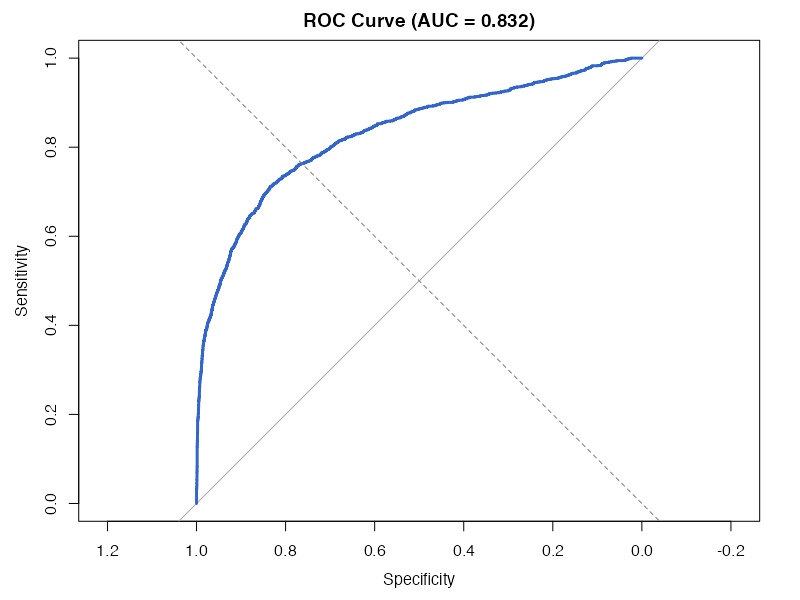

Warning message:
Removed 2 rows containing missing values or values outside the scale range (`geom_line()`). 


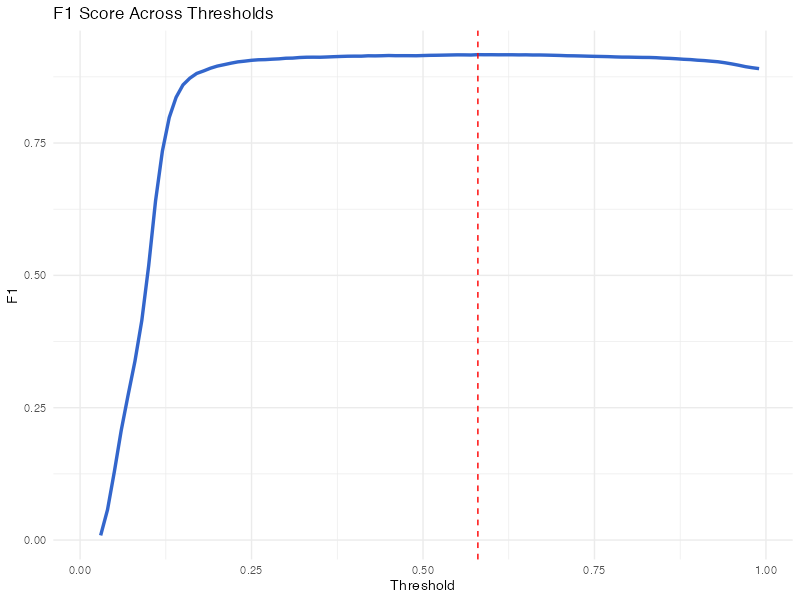

In [5]:
svm_model <- train(
  resp ~ ., 
  data = df,
  method = "svmRadial",
  trControl = ctrl,
  tuneLength = 7,     # tunes C + sigma (gamma)
  preProcess = NULL,
  metric = "Accuracy"
)

svm_model
best_params <- svm_model$bestTune
print(best_params)

# Extract predictions from all CV folds
pred_df <- svm_model$pred %>%
  filter(C == best_params$C, sigma == best_params$sigma) %>%
  mutate(obs = factor(obs, levels = c("No", "Yes")))

# ============================================================
# 5. PERFORMANCE AT DEFAULT THRESHOLD 0.5
# ============================================================

default_preds <- factor(ifelse(pred_df$Yes >= 0.5, "Yes", "No"), 
                        levels = c("No", "Yes"))

cm_default <- confusionMatrix(default_preds, pred_df$obs)
cm_default

# ============================================================
# 6. ROC CURVE + AUC
# ============================================================

roc_obj <- roc(response = pred_df$obs, predictor = pred_df$Yes)
auc_value <- auc(roc_obj)
cat("AUC =", round(auc_value, 3), "\n")

plot(
  roc_obj,
  col="#3366CC",
  lwd=3,
  main=sprintf("ROC Curve (AUC = %.3f)", auc_value)
)
abline(a = 0, b = 1, col="gray50", lty=2)

# ============================================================
# 7. AUTOMATIC THRESHOLD TUNING (MAX F1)
# ============================================================

thresholds <- seq(0.01, 0.99, 0.01)

metric_table <- data.frame(
  threshold = thresholds,
  Accuracy = NA,
  Sensitivity = NA,
  Specificity = NA,
  F1 = NA
)

for (i in seq_along(thresholds)) {
  
  t <- thresholds[i]
  
  preds_t <- factor(ifelse(pred_df$Yes >= t, "Yes", "No"),
                    levels = c("No", "Yes"))
  
  cm <- confusionMatrix(preds_t, pred_df$obs)
  
  metric_table$Accuracy[i]    <- cm$overall["Accuracy"]
  metric_table$Sensitivity[i] <- cm$byClass["Sensitivity"]
  metric_table$Specificity[i] <- cm$byClass["Specificity"]
  metric_table$F1[i]          <- cm$byClass["F1"]
}

# ---- Best threshold ----
best_idx <- which.max(metric_table$F1)
best_threshold <- metric_table$threshold[best_idx]
best_stats <- metric_table[best_idx, ]

cat("\nBEST THRESHOLD =", best_threshold, "\n")
print(best_stats)

# ============================================================
# 8. F1 VS THRESHOLD PLOT
# ============================================================

ggplot(metric_table, aes(x = threshold, y = F1)) +
  geom_line(color="#3366CC", linewidth=1.2) +
  geom_vline(xintercept = best_threshold, color="red", linetype="dashed") +
  labs(
    title = "F1 Score Across Thresholds",
    x = "Threshold",
    y = "F1"
  ) +
  theme_minimal()

# ============================================================
# 9. FINAL CONFUSION MATRIX AT OPTIMAL THRESHOLD
# ============================================================

final_preds <- factor(ifelse(pred_df$Yes >= best_threshold, "Yes", "No"),
                      levels = c("No", "Yes"))

cm_final <- confusionMatrix(final_preds, pred_df$obs)
cm_final


After tuning both the SVM hyperparameters (C and sigma) and the classification threshold, the model achieved strong performance on the churn dataset. The optimized model reached an AUC of 0.832, indicating solid discriminative ability. Threshold tuning identified 0.58 as the optimal cutoff for converting predicted probabilities into class labels. At this threshold, the model produced an F1 score of 0.917, with 97.9% sensitivity, meaning it detected nearly all customers who churn. This comes at the cost of lower specificity (38.8%), which is expected given the goal of prioritizing churn detection. The ROC curve and F1-vs-threshold analysis both demonstrate stable and reliable probability estimates. Overall, the tuned SVM model is effective for churn prediction and performs significantly better than untuned models.

## Random Forest Modeling: 

## Logistic Regression Modeling: